In [112]:
import os, glob, string, re, datetime
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/thomasvetterli/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Extracting the Data
Know that we have learned that we will not be able to process the data using a Spark pipeline, we will implement here a Python pipeline to read the files.

## 1 - Extracting the paths

We first have to get all the paths containing the XML files.

In [2]:
GDL = 'GDL'
JDG = 'JDG'
listFiles = []

#Go through all the files of both journals
for root, dirs, files in os.walk(GDL): 
    for file in files:
        if file.endswith('.xml'):
             listFiles.append(os.path.join(root, file))

for root, dirs, files in os.walk(JDG): 
    for file in files:
        if file.endswith('.xml'):
             listFiles.append(os.path.join(root, file))

Now that we have the path for each file in the dataset, we can work through each of them and count words. We will use the method described in **Filtering the Data.ipynb**

## 2 - Extracting the word count
Know that we have the paths for all text files, we can read the text and then clean it.

First we need the stop words.

In [3]:
stop_words = list(stopwords.words('french'))
stop_words.extend(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']',
                   '{', '}', '<', '>', '...', '-', '•', '/', '%', '«', '»', 'le',
                  'les','..','©','plus','*','``','av','p.','fr','cette','a.','v.','b.','d.',
                   'c.','e.','f.','i.','g.','h.','i.','j.','l.','m.','n.','o.','q.','r.','q.',
                   's.','t.','u.','v.','w.','x.','z.','y.',"d'un","d'une",'dm',"c'est",
                   "jusqu'au",'entre','comme','si','di','„','&',"qu'il",'_','fd',"n'a",'alors',
                   "s'est","n'est",'cs','dès','où',"jusqu'à",'déjà',"''",'|','£','®','+','-«',
                   '--','.-',"la",'---','-le','-n','î','â'])

stop_words.extend(['','-.','.,','(,','»,',').','-.','av.','».',
                      '....','..','...','.....','()','(r).','—',')-«',
                      '".','-,','(-.',')-.','(©','™','--','---','—•','•-',
                  '•','••','•••','•••','—la','ï',"'la",'•—',
                  '——','û','ê','ë','ù',"'la",'•—','——','—le',"'''","''",
                  "'","'le","'la","'i",'-on',"•'","'-","-'","a'","'de","'la",
                  "'â","aa","'-","-de","-et",'-on','-les',',,,', '——•','•-•',
                  '„„','•—•'])
stop_words.extend(list(string.ascii_lowercase))

And preparing the dictionaries.

In [4]:
listPunct = list(string.punctuation)
listPunct.remove("'")
listPunct.remove("-")
#we do not want to stick together all the words that
#have an apostrophe (l'armée should not become larmée)
stopDict = dict(zip(listPunct,['']*len(listPunct)))

We also need a constant which tells us how many of the most frequenc words we take.

In [5]:
numMostFreq = 1000

And then we can go through the list to extract the data in each file. We also set a counter to see how long it takes.

We first extract the data in 43 different dataframes, otherwise the algorithm's complexity is too high and the process is endless.

In [6]:
total = len(listFiles)
allText = []

In [20]:
for idx, file in enumerate(listFiles):   
    #counter 
    counter(idx)
    #find the date at which the article is published.
    date = pd.to_datetime(file[4:11])
    #Open the XML
    f = open(file,'r')
    soupArticle = BeautifulSoup(f,'lxml')
    f.close()
    
    #Extracting the entire text from the XML
    Article = []
    for ft in soupArticle.find_all('full_text'):
        #Here we lower each words and we remove the numbers from the text
        Article.append(re.sub(r'\d+', '', ft.text).lower())

    textArticle = ' '.join(Article)  
    
    #Cleaning and counting
    for k,v in stopDict.items():
        textArticle = textArticle.replace(k,v)

    dictCounter = [wordsDict for wordsDict in textArticle.split(' ') if wordsDict not in stop_words]
    countDict = Counter(dictCounter).most_common(numMostFreq)
    
    #Transofming to a dataframe
    df = pd.DataFrame(countDict).transpose()
    df.columns = df.loc[0]
    df.drop(0,inplace=True)
    df.index = [date]
    allText.append(df)
    
    if idx > 0:
        if idx%106 == 0:
            dfAllText = pd.concat(allText,axis=0)
            dfAllText.to_csv('Data/Part_'+str(idx)+'.csv')
            del allText
            allText = []
  

We are at : 0.0  %
We are at : 2.306805074971165  %
We are at : 4.61361014994233  %
We are at : 6.920415224913495  %
We are at : 9.22722029988466  %
We are at : 11.534025374855824  %
We are at : 13.84083044982699  %
We are at : 16.147635524798154  %
We are at : 18.45444059976932  %
We are at : 20.761245674740483  %
We are at : 23.06805074971165  %
We are at : 25.37485582468281  %
We are at : 27.68166089965398  %
We are at : 29.988465974625143  %
We are at : 32.29527104959631  %
We are at : 34.602076124567475  %
We are at : 36.90888119953864  %
We are at : 39.21568627450981  %
We are at : 41.522491349480966  %
We are at : 43.82929642445214  %
We are at : 46.1361014994233  %
We are at : 48.44290657439446  %
We are at : 50.74971164936562  %
We are at : 53.05651672433679  %
We are at : 55.36332179930796  %
We are at : 57.67012687427913  %
We are at : 59.976931949250286  %
We are at : 62.28373702422145  %
We are at : 64.59054209919262  %
We are at : 66.89734717416378  %
We are at : 69.20415

In [16]:
dfAllText.head()

,abfens,abfolument,abus,accepte,accepté,acceptée,accorde,accordé,actifs,actions,...,éprouve,éprouvé,établi,état,étoit,évacué,événemens,événement,être,île
1799-06-01,NaN,NaN,NaN,17,NaN,NaN,9,11,NaN,NaN,...,NaN,NaN,14,16,7,NaN,NaN,7,114,9
1799-07-01,NaN,10,8,15,NaN,NaN,NaN,10,NaN,8,...,NaN,NaN,10,23,NaN,NaN,NaN,12,154,10
1799-08-01,NaN,NaN,9,13,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25,NaN,NaN,NaN,9,185,12
1799-09-01,8,8,NaN,14,8,9,NaN,NaN,8,NaN,...,NaN,NaN,NaN,19,NaN,NaN,NaN,11,112,8
1799-10-01,NaN,10,NaN,13,NaN,10,NaN,NaN,NaN,NaN,...,8,8,12,34,9,9,9,13,103,NaN


Now that we have all the separate dataframes we can implement a function to concatenate them together.

In [4]:
csvFiles = []

for root, dirs, files in os.walk('Data'): 
    for file in files:
        if file.endswith('.csv'):
             csvFiles.append(os.path.join(root, file))

In [5]:
test = []
for idx, item in enumerate(csvFiles):
    if idx == 0:
        test.append(pd.read_csv(item))
    elif idx == 1:
        test.append(pd.read_csv(item))
        dfFinal = pd.concat(test,axis=0)
    
    else:
        dfFinal = pd.concat([dfFinal,pd.read_csv(item)],axis=0)
    
    print('Run : ',idx,' at ', datetime.datetime.now().time())

Run :  0  at  09:09:43.045679
Run :  1  at  09:09:45.542397
Run :  2  at  09:09:48.359610
Run :  3  at  09:09:51.181534
Run :  4  at  09:09:54.312439
Run :  5  at  09:09:57.432953
Run :  6  at  09:10:01.019007
Run :  7  at  09:10:05.182603
Run :  8  at  09:10:10.055133
Run :  9  at  09:10:15.761222
Run :  10  at  09:10:22.311220
Run :  11  at  09:10:33.929625
Run :  12  at  09:10:42.646545
Run :  13  at  09:10:51.149244
Run :  14  at  09:11:03.792580
Run :  15  at  09:11:23.245710
Run :  16  at  09:11:44.802413
Run :  17  at  09:12:07.563454
Run :  18  at  09:12:26.272846
Run :  19  at  09:12:43.962975
Run :  20  at  09:13:00.166146
Run :  21  at  09:13:19.615180
Run :  22  at  09:13:45.152176
Run :  23  at  09:14:07.562615
Run :  24  at  09:14:30.584229
Run :  25  at  09:14:53.798456
Run :  26  at  09:15:17.634364
Run :  27  at  09:15:44.920863
Run :  28  at  09:16:10.463351
Run :  29  at  09:16:34.281972
Run :  30  at  09:16:57.418405
Run :  31  at  09:17:25.357646
Run :  32  at  09:

Now we look at the results!

In [13]:
print('Number of words : ',dfFinal.shape[0])

Number of words :  4335


We have a lot of words, as we saw before, we still have a lot of unwanted words.

In [14]:
dfFinal.head()

,'''',''''','''''',''-,''»,''•,'-','--,'a,'aisi,...,—•—,—•—•,•«,•»,•—•—,••',••••,•••••,••••••,€
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dfFinal.shape

(4335, 32413)

# Functions for the extractions

In [8]:
def counter(i):
    if i%100==0:
        print('We are at :', i/total*100 ,' %')

In [16]:
pd.read_csv('Data/Part_4028.csv').head()

,Unnamed: 0,'''',''''','''''','-','a,'au,'c,'ce,'d,...,être,ô,œcuménique,œuvre,œuvres,—c,—d,—ex,—o,€
0,1963-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,943,NaN,NaN,156,114.0,NaN,942.0,NaN,NaN,NaN
1,1963-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,927,NaN,NaN,118,130.0,NaN,832.0,NaN,NaN,NaN
2,1964-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1007,NaN,NaN,123,95.0,NaN,1146.0,NaN,85.0,NaN
3,1964-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1021,NaN,NaN,151,153.0,NaN,973.0,NaN,100.0,NaN
4,1964-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,886,NaN,NaN,121,113.0,NaN,1091.0,NaN,101.0,NaN


In [37]:
listDF = []
for idx, item in enumerate(csvFiles):
    listDF.append(pd.read_csv(item,index_col=0))

In [38]:
finalDF = pd.concat(listDF,axis=0)
finalDF.head()

,'''',''''','''''',''-,''»,''•,'-','--,'a,'aisi,...,—•—,—•—•,•«,•»,•—•—,••',••••,•••••,••••••,€
1798-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
tot=0
for i,item in enumerate(listDF):
    tot+=item.shape[1]

In [41]:
pd.read_csv('Data/Part_4028.csv',index_col=0).shape

(106, 2846)

# Cleaning the data

Know we have a lot of columns thta we were not able to clean out, we therefore have to delete what is not of interest to us.

In [ ]:
finalDF = finalDF.fillna(0)

In [79]:
finalDF.ix[:,0:236].head()

,'''',''''','''''',''-,''»,''•,'-','--,'a,'aisi,...,a'court,a-,a-c,a-k,a-l-il,a-t,a-t-,a-t-il,a-t-on,aaa
1798-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
DFClean_0 = finalDF.drop(finalDF.columns[0:236],axis=1)
DFClean_0.head()

,aaland,aalen,aap,aar,aarau,aarberg,aax,aay,ab,ab-intestat,...,—•—,—•—•,•«,•»,•—•—,••',••••,•••••,••••••,€
1798-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
DFClean_1 = DFClean_0.drop(DFClean_0.columns[32090:32176],axis=1)

In [105]:
GroupYear = DFClean_1.groupby(DFClean_1.index)

In [109]:
wordCountYear = GroupYear.agg(sum)

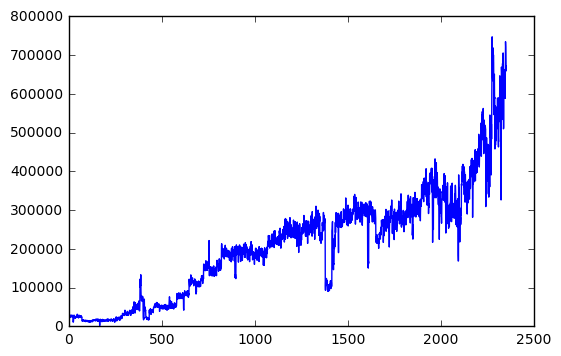

In [114]:
plt.plot(wordCountYear.sum(axis=1).values)

In [121]:
wordCountYear.index = pd.to_datetime(wordCountYear.index)

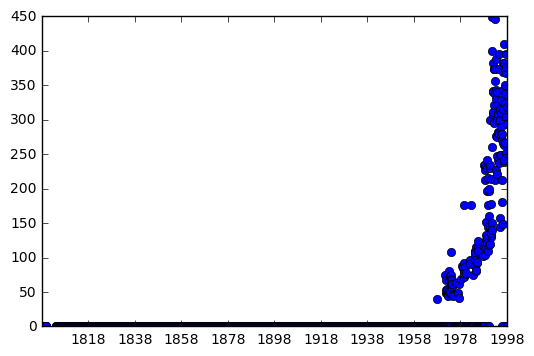

In [130]:
plt.plot_date(wordCountYear.index,wordCountYear['week-end'].values)

In [134]:
wordCountYear.to_csv('Data/wordCountYear.csv')

(array([  3.09220000e+04,   3.13000000e+02,   1.41000000e+02,
          1.96000000e+02,   1.18000000e+02,   9.60000000e+01,
          6.50000000e+01,   5.30000000e+01,   3.70000000e+01,
          3.70000000e+01,   1.80000000e+01,   1.50000000e+01,
          1.10000000e+01,   9.00000000e+00,   6.00000000e+00,
          1.00000000e+01,   5.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

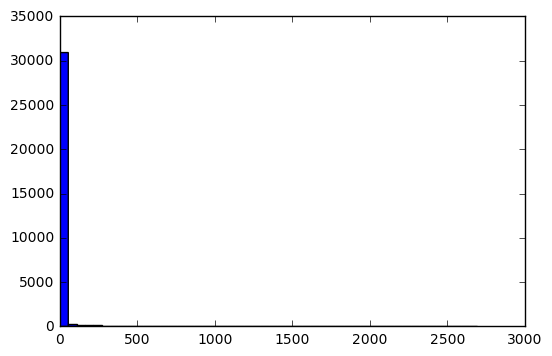

In [139]:
plt.hist(wordCountYear.loc[wordCountYear.index[2000]].values,bins=50)    